###ライブラリ

In [248]:
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import ensemble, svm, linear_model
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('precision',3)
pd.set_option('max_columns',100)

#-----------------------------------------------------------------------------------------
def check_input_rate(df):
    
    df = pd.concat([df.dtypes,                            #型
                                df.count(),                           #入力数
                                len(df) - df.count(),            #NaN数
                                df.count() / len(df) * 100 #入力率
                                ], axis=1)
    df.columns = ["型","入力数","NaN数","入力率"]
    
    return df

#-----------------------------------------------------------------------------------------
def check_column_data(df, value):
    
    df = df.replace(np.NaN, "null") #NaNをカウントするため置換
    df = pd.concat([df.groupby(value).size(), 
                                df.groupby(value).size() / df[value].count() * 100],
                                axis = 1)
    df = df.rename(index={"null":"NaN"},
                               columns = {0:"件数", 1:"割合"})
    
    return df

#-----------------------------------------------------------------------------------------
def check_evaluation(test_cls, pred_cls):
    
    #混同行列
    matrix = pd.DataFrame(confusion_matrix(test_cls, pred_cls))
    matrix.columns.name, matrix.index.name = "予測", "実績"
    display(matrix)

    #評価
    p, r, f, s = precision_recall_fscore_support(test_cls, pred_cls, beta=0.5)
    evaluation = pd.DataFrame({'precision': p, 'recall': r, 'score(F)': f, 'support':s})
    display(evaluation)

###データ - 読込

In [250]:
#names = ["survived","pclass","sex","age","sibsp","fare","embarked","class","who","adult_male","deck","embark_town","alive","alone"]
#data= pandas.read_csv("./xxxx.tsv", sep = "\t", header = None, names = names)
data = sns.load_dataset("titanic")
data.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22,1,0,7.25,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38,1,0,71.28,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26,0,0,7.92,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35,1,0,53.10,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35,0,0,8.05,S,Third,man,True,NaN,Southampton,no,True


###データ - 型変換

In [251]:
## null文字 to NaN
data = data.replace("null", np.NaN)

## date to datetime64型
data["ver"] = "2015-01-01"
data["ver"] = pd.to_datetime(data["ver"])

###データ - 各カラムの入力率

In [252]:
check_input_rate(data).T

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,ver
型,int64,int64,object,float64,int64,int64,float64,object,object,object,bool,object,object,object,bool,datetime64[ns]
入力数,891,891,891,714,891,891,891,889,891,891,891,203,889,891,891,891
NaN数,0,0,0,177,0,0,0,2,0,0,0,688,2,0,0,0
入力率,100,100,100,80.1,100,100,100,99.8,100,100,100,22.8,99.8,100,100,100


###データ - 特徴選択

In [253]:
###NaNレコード削除
data = data.dropna(subset=["age","embarked"]) 
###不要カラム削除
data = data.drop(["deck","sibsp","fare","adult_male","embark_town","alive","alone"], axis = 1)
###INDEXリセット
data = data.reset_index(drop = True)

check_input_rate(data).T

,survived,pclass,sex,age,parch,embarked,class,who,ver
型,int64,int64,object,float64,int64,object,object,object,datetime64[ns]
入力数,712,712,712,712,712,712,712,712,712
NaN数,0,0,0,0,0,0,0,0,0
入力率,100,100,100,100,100,100,100,100,100


###データ - 基礎統計量等

In [254]:
print("基礎統計量")
display(data.describe())

print("各カラムの入力データ割合")
for column in data.columns:
    display(check_column_data(data, column).sort("件数", ascending=False).T) #降順･転置

基礎統計量


,survived,pclass,age,parch
count,712.00,712.00,712.00,712.00
mean,0.40,2.24,29.64,0.43
std,0.49,0.84,14.49,0.85
min,0.00,1.00,0.42,0.00
25%,0.00,1.00,20.00,0.00
50%,0.00,2.00,28.00,0.00
75%,1.00,3.00,38.00,1.00
max,1.00,3.00,80.00,6.00


各カラムの入力データ割合


survived,0,1
件数,424.00,288.00
割合,59.55,40.45


pclass,3,1,2
件数,355.00,184.00,173.0
割合,49.86,25.84,24.3


sex,male,female
件数,453.00,259.00
割合,63.62,36.38


age,24.0,22.0,18.0,30.0,28.0,19.0,21.0,25.0,36.0,29.0,32.0,35.0,27.0,26.0,31.0,16.0,23.0,34.0,20.0,33.0,39.0,40.0,42.0,17.0,45.0,2.0,4.0,50.0,38.0,48.0,47.0,44.0,9.0,54.0,1.0,51.0,41.0,37.0,49.0,14.0,3.0,52.0,43.0,58.0,15.0,8.0,5.0,56.0,60.0,11.0,7.0,62.0,65.0,46.0,61.0,6.0,64.0,0.83,55.0,57.0,0.75,10.0,45.5,32.5,71.0,13.0,40.5,70.0,59.0,30.5,63.0,28.5,74.0,70.5,66.0,0.42,55.5,53.0,36.5,34.5,0.67,24.5,23.5,20.5,14.5,12.0,0.92,80.0
件数,30.00,27.00,26.00,25.00,25.00,25.00,24.00,23.00,22.00,20.00,18.00,18.00,18.00,18.00,17.00,17.00,15.00,15.00,15.00,15.00,14.00,13.00,13.00,13.00,12.00,10.0,10.0,10.0,10.0,9.00,9.00,9.00,8.00,8.00,7.00,7.00,6.00,6.00,6.00,6.00,6.00,6.00,5.0,5.0,5.0,4.00,4.00,4.00,4.00,4.00,3.00,3.00,3.00,3.00,3.00,3.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
割合,4.21,3.79,3.65,3.51,3.51,3.51,3.37,3.23,3.09,2.81,2.53,2.53,2.53,2.53,2.39,2.39,2.11,2.11,2.11,2.11,1.97,1.83,1.83,1.83,1.69,1.4,1.4,1.4,1.4,1.26,1.26,1.26,1.12,1.12,0.98,0.98,0.84,0.84,0.84,0.84,0.84,0.84,0.7,0.7,0.7,0.56,0.56,0.56,0.56,0.56,0.42,0.42,0.42,0.42,0.42,0.42,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14


parch,0,1,2,3,5,4,6
件数,519.00,110.00,68.00,5.0,5.0,4.00,1.00
割合,72.89,15.45,9.55,0.7,0.7,0.56,0.14


embarked,S,C,Q
件数,554.00,130.00,28.00
割合,77.81,18.26,3.93


class,Third,First,Second
件数,355.00,184.00,173.0
割合,49.86,25.84,24.3


who,man,woman,child
件数,413.00,216.00,83.00
割合,58.01,30.34,11.66


ver,2015-01-01 00:00:00
件数,712
割合,100


###前処理 - ビン化
連続数値を各区分にグループ化

In [255]:
#age
bins = [0,10,20,30,40,50,60,100]
labels = [1,2,3,4,5,6,7]
data["age_b"] = pd.cut(data.age, bins, labels = labels, right = False) #左閉空間
display(check_column_data(data, "age_b").rename(index = {1:"10代未満", 2:"10代", 3:"20代", 4:"30代", 5:"40代", 6:"50代", 7:"60代以上", "null":"NaN"}).T)

age_b,10代未満,10代,20代,30代,40代,50代,60代以上
件数,62.00,102.00,220.0,166.00,89.0,48.00,25.00
割合,8.71,14.33,30.9,23.31,12.5,6.74,3.51


###前処理 - ダミー化
カテゴリ変数を0/1のデータに変換(One-hot-encoding)

In [256]:
for col in ["who","embarked","class","sex"]:
    data = pd.merge(data, pd.get_dummies(data[col], prefix = col), how="inner", left_index = True,  right_index = True)
else:
    display(data.head(5))

,survived,pclass,sex,age,parch,embarked,class,who,ver,age_b,who_child,who_man,who_woman,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third,sex_female,sex_male
0,0,3,male,22,0,S,Third,man,2015-01-01,3,0,1,0,0,0,1,0,0,1,0,1
1,1,1,female,38,0,C,First,woman,2015-01-01,4,0,0,1,1,0,0,1,0,0,1,0
2,1,3,female,26,0,S,Third,woman,2015-01-01,3,0,0,1,0,0,1,0,0,1,1,0
3,1,1,female,35,0,S,First,woman,2015-01-01,4,0,0,1,0,0,1,1,0,0,1,0
4,0,3,male,35,0,S,Third,man,2015-01-01,4,0,1,0,0,0,1,0,0,1,0,1


###前処理 - 正規化
各特徴量の重要性を均一化

In [257]:
for col in ["age","pclass"]:
    mean = data[col].mean()
    std = data[col].std()
    data[col + "_n"] = (data[col] - mean) / std
    print("{0} 平均:{1:.3f} 標準偏差:{2:.3f}".format(col, mean, std))
else:    
    display(data.head(5))

age 平均:29.642 標準偏差:14.493
pclass 平均:2.240 標準偏差:0.837


,survived,pclass,sex,age,parch,embarked,class,who,ver,age_b,who_child,who_man,who_woman,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third,sex_female,sex_male,age_n,pclass_n
0,0,3,male,22,0,S,Third,man,2015-01-01,3,0,1,0,0,0,1,0,0,1,0,1,-0.53,0.91
1,1,1,female,38,0,C,First,woman,2015-01-01,4,0,0,1,1,0,0,1,0,0,1,0,0.58,-1.48
2,1,3,female,26,0,S,Third,woman,2015-01-01,3,0,0,1,0,0,1,0,0,1,1,0,-0.25,0.91
3,1,1,female,35,0,S,First,woman,2015-01-01,4,0,0,1,0,0,1,1,0,0,1,0,0.37,-1.48
4,0,3,male,35,0,S,Third,man,2015-01-01,4,0,1,0,0,0,1,0,0,1,0,1,0.37,0.91


###前処理 - 特徴エンジニアリング
既存の特徴量から計算された新たな特徴量を作成

In [258]:
#男性で乗船クラスが低い(数値が小さい)ほど生存率が低いと仮定
data['pclass_gender'] = data["pclass"] + data['who_man']
data.head(5)

,survived,pclass,sex,age,parch,embarked,class,who,ver,age_b,who_child,who_man,who_woman,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third,sex_female,sex_male,age_n,pclass_n,pclass_gender
0,0,3,male,22,0,S,Third,man,2015-01-01,3,0,1,0,0,0,1,0,0,1,0,1,-0.53,0.91,4
1,1,1,female,38,0,C,First,woman,2015-01-01,4,0,0,1,1,0,0,1,0,0,1,0,0.58,-1.48,1
2,1,3,female,26,0,S,Third,woman,2015-01-01,3,0,0,1,0,0,1,0,0,1,1,0,-0.25,0.91,3
3,1,1,female,35,0,S,First,woman,2015-01-01,4,0,0,1,0,0,1,1,0,0,1,0,0.37,-1.48,1
4,0,3,male,35,0,S,Third,man,2015-01-01,4,0,1,0,0,0,1,0,0,1,0,1,0.37,0.91,4


###学習データ・テストデータ作成

In [259]:
#不要カラム削除
data = data.drop(["sex","age", "embarked","class","who","ver"], axis = 1)
#説明変数名取得
columns = data.columns[1:]

#学習データ・テストデータ取得
features = data[columns]
cls = data.survived
train_features, test_features, train_cls, test_cls = cross_validation.train_test_split(features, cls, train_size=0.8, random_state=0)

###Random Forest

In [260]:
#Grid-Search
estimator = ensemble.RandomForestClassifier()
param_grid = {
        'n_estimators'      : [10,20,30],
        'n_jobs'            : [1],
        'min_samples_split' : [2],
        'min_samples_leaf'  : [1]
}
model = grid_search.GridSearchCV(estimator, param_grid)

#Fit-Predict
model.fit(train_features, train_cls)
pred_cls = model.predict(test_features)

#Importance
importances = pd.DataFrame(columns)
importances["value"] = model.best_estimator_.feature_importances_
display(importances.sort("value", ascending=False).T)

#Evaluation
check_evaluation(test_cls, pred_cls)

,14,16,12,2,13,1,0,4,15,5,6,3,9,8,7,10,11
0,age_n,pclass_gender,sex_female,age_b,sex_male,parch,pclass,who_man,pclass_n,who_woman,embarked_C,who_child,class_First,embarked_S,embarked_Q,class_Second,class_Third
value,0.294,0.156,0.151,0.0763,0.0542,0.0458,0.0446,0.0443,0.0291,0.027,0.0241,0.013,0.0126,0.0117,0.00793,0.00664,0.00209


予測,0,1
実績,,
0,67,15
1,17,44


,precision,recall,score(F),support
0,0.80,0.82,0.80,82
1,0.75,0.72,0.74,61


###K-FoldCrossValidation
データセットをK個にブロックに分割し、1つのブロックを除いたデータ集合でモデルを学習し、残りのブロックで評価を行うことをK回繰り返す交差検定は汎化能力を持つか判断するためであり、最終的なモデルは全データセットを利用する

In [261]:
kf = cross_validation.KFold(len(features), n_folds = 5)
precision_list = []
recall_list = []

for train_index, test_index in kf:
    
    model.fit(features.iloc[train_index], cls[train_index])
    pred_cls = model.predict(features.iloc[test_index])
    precision_list.append(precision_score(cls[test_index], pred_cls, average = None)[1] )
    recall_list.append(recall_score(cls[test_index], pred_cls, average = None)[1] )

print("適合率", np.mean(precision_list))
print("再現率", np.mean(recall_list))

適合率 0.715172426078
再現率 0.659336219336


###　決定木

```
$ pip install pydot,pydotplus,pyparsing,graphviz
$ brew install graphviz
```

In [1]:
import pydot
import pydotplus
from pyparsing import *
from graphviz import Digraph
from PIL import Image
from sklearn import tree
from sklearn.externals.six import StringIO
from sklearn.datasets import load_iris

In [2]:
iris = load_iris()
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(iris.data, iris.target)

In [6]:
#dot形式⇒PDF
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data, class_names=iris.target_names,feature_names=iris.feature_names)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph[0].write_pdf("graph2.pdf")

True

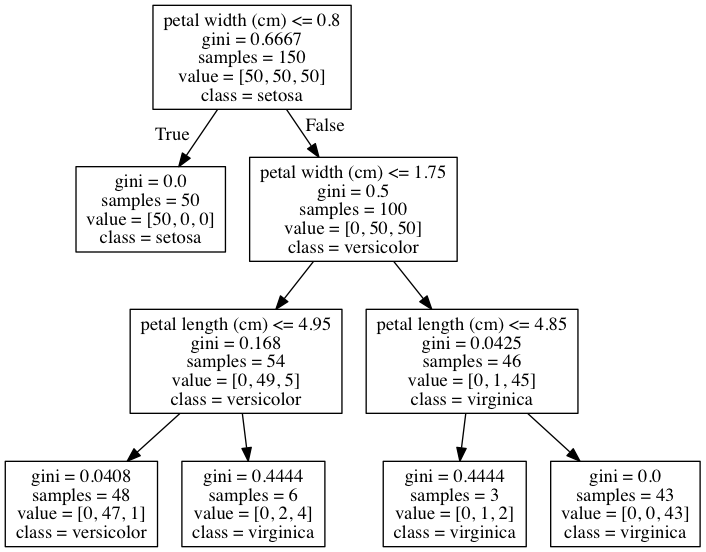

In [13]:
from IPython.display import *
Image(graph[0].create_png())